In [0]:
mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
# All the imports required
import os
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import torch
import math
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data.dataloader import default_collate
import numpy as np
from random import uniform
import cv2

In [0]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCdevkit_08-Jun-2007.tar

--2019-04-14 17:05:08--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  13.6MB/s    in 33s     

2019-04-14 17:05:41 (13.3 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2019-04-14 17:05:43--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

In [0]:
ls

data/         VOCdevkit_08-Jun-2007.tar  VOCtrainval_06-Nov-2007.tar
sample_data/  VOCtest_06-Nov-2007.tar


In [0]:
mv VOC* data/

In [0]:
cd data/

/content/data


In [0]:
!tar xvf VOCtrainval_06-Nov-2007.tar
!tar xvf VOCtest_06-Nov-2007.tar
!tar xvf VOCdevkit_08-Jun-2007.tar

VOCdevkit/
VOCdevkit/VOC2007/
VOCdevkit/VOC2007/Annotations/
VOCdevkit/VOC2007/Annotations/000005.xml
VOCdevkit/VOC2007/Annotations/000007.xml
VOCdevkit/VOC2007/Annotations/000009.xml
VOCdevkit/VOC2007/Annotations/000012.xml
VOCdevkit/VOC2007/Annotations/000016.xml
VOCdevkit/VOC2007/Annotations/000017.xml
VOCdevkit/VOC2007/Annotations/000019.xml
VOCdevkit/VOC2007/Annotations/000020.xml
VOCdevkit/VOC2007/Annotations/000021.xml
VOCdevkit/VOC2007/Annotations/000023.xml
VOCdevkit/VOC2007/Annotations/000024.xml
VOCdevkit/VOC2007/Annotations/000026.xml
VOCdevkit/VOC2007/Annotations/000030.xml
VOCdevkit/VOC2007/Annotations/000032.xml
VOCdevkit/VOC2007/Annotations/000033.xml
VOCdevkit/VOC2007/Annotations/000034.xml
VOCdevkit/VOC2007/Annotations/000035.xml
VOCdevkit/VOC2007/Annotations/000036.xml
VOCdevkit/VOC2007/Annotations/000039.xml
VOCdevkit/VOC2007/Annotations/000041.xml
VOCdevkit/VOC2007/Annotations/000042.xml
VOCdevkit/VOC2007/Annotations/000044.xml
VOCdevkit/VOC2007/Annotations/000046.

### Data Prep, Expansion

In [0]:
#Data Prep
class VOCDataset(Dataset):
    def __init__(self, root_path="data/VOCdevkit", year="2007", mode="train", image_size=448, is_training = True):
        #Data prep
        if (mode in ["train", "val", "trainval", "test"] and year == "2007") or (
                mode in ["train", "val", "trainval"] and year == "2012"):
            self.data_path = os.path.join(root_path, "VOC{}".format(year))
            print(self.data_path)
        self.data_path = os.path.join(root_path, "VOC{}".format(year))
        print(root_path)
        print(self.data_path)
        id_list_path = os.path.join(self.data_path, "ImageSets/Main/{}.txt".format(mode))
        self.ids = [id.strip() for id in open(id_list_path)]
        self.classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                        'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
                        'tvmonitor']
        self.image_size = image_size
        self.num_classes = len(self.classes)
        self.num_images = len(self.ids)
        self.is_training = is_training

    def __len__(self):
        return self.num_images

    def __getitem__(self, item):
        id = self.ids[item]
        image_path = os.path.join(self.data_path, "JPEGImages", "{}.jpg".format(id))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_xml_path = os.path.join(self.data_path, "Annotations", "{}.xml".format(id))
        annot = ET.parse(image_xml_path)
        
        objects = [] #stores all the detecteed objects, with the x, y and class
        for obj in annot.findall('object'):
            xmin, xmax, ymin, ymax = [int(obj.find('bndbox').find(tag).text) - 1 for tag in
                                      ["xmin", "xmax", "ymin", "ymax"]]
            label = self.classes.index(obj.find('name').text.lower().strip())
            objects.append([xmin, ymin, xmax, ymax, label])
        if self.is_training:
            transformations = Compose([HSVAdjust(), VerticalFlip(), Crop(), Resize(self.image_size)])
        else:
            transformations = Compose([Resize(self.image_size)])
        image, objects = transformations((image, objects))

        return np.transpose(np.array(image, dtype=np.float32), (2, 0, 1)), np.array(objects, dtype=np.float32)

## Utils



### **Direct location prediction**

We make predictions on the offsets to the anchors. Nevertheless, if it is unconstrained, our guesses will be randomized again. YOLO predicts 5 parameters (tx, ty, tw, th, and to) and applies the sigma function to constraint its possible offset range.

![alt text](https://cdn-images-1.medium.com/max/640/1*38-Tdx-wQA7c3TX5hdnwpw.jpeg)

![alt text](https://cdn-images-1.medium.com/max/640/1*gyOSRA_FDz4Pf5njoUb4KQ.jpeg)

![YOlo!](https://cdn-images-1.medium.com/max/640/1*0IPktA65WxOBfP_ULQWcmw.png)


### **NMS: Non-maximal suppression**

YOLO can make duplicate detections for the same object. To fix this, YOLO applies non-maximal suppression to remove duplications with lower confidence. Non-maximal suppression adds 2- 3% in mAP.

Here is one of the possible non-maximal suppression implementation:

1.   Sort the predictions by the confidence scores.

2.   Start from the top scores, ignore any current prediction if we find any previous predictions that have the same class and IoU > 0.5 with the current prediction.

3.   Repeat step 2 until all predictions are checked.


In [0]:
# utils
"""
      Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
      This describes how to combine these tensors of different sizes. We use lists.
      Note: this need not be defined in this Class, can be standalone.
      :param batch: an iterable of N sets from __getitem__()
      :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
"""
def custom_collate_fn(batch):
    items = list(zip(*batch))
    items[0] = default_collate(items[0])
    items[1] = list(items[1])
    return items

"""
    Used to process the output of the model into proper predictions
"""
def post_processing(logits, image_size, gt_classes, anchors, conf_threshold, nms_threshold):
    num_anchors = len(anchors)
    # get all the coordinatees from the input data
    anchors = torch.Tensor(anchors)
    if isinstance(logits, Variable):
        logits = logits.data

    if logits.dim() == 3:
        logits.unsqueeze_(0)

    batch = logits.size(0)
    h = logits.size(2)
    w = logits.size(3)

    # Compute xc,yc, w,h, box_score on Tensor
    lin_x = torch.linspace(0, w - 1, w).repeat(h, 1).view(h * w)
    lin_y = torch.linspace(0, h - 1, h).repeat(w, 1).t().contiguous().view(h * w)
    anchor_w = anchors[:, 0].contiguous().view(1, num_anchors, 1)
    anchor_h = anchors[:, 1].contiguous().view(1, num_anchors, 1)
    if torch.cuda.is_available():
        lin_x = lin_x.cuda()
        lin_y = lin_y.cuda()
        anchor_w = anchor_w.cuda()
        anchor_h = anchor_h.cuda()
    logits = logits.view(batch, num_anchors, -1, h * w)
    logits[:, :, 0, :].sigmoid_().add_(lin_x).div_(w)
    logits[:, :, 1, :].sigmoid_().add_(lin_y).div_(h)
    logits[:, :, 2, :].exp_().mul_(anchor_w).div_(w)
    logits[:, :, 3, :].exp_().mul_(anchor_h).div_(h)
    logits[:, :, 4, :].sigmoid_()

    with torch.no_grad():
        cls_scores = torch.nn.functional.softmax(logits[:, :, 5:, :], 2)
    cls_max, cls_max_idx = torch.max(cls_scores, 2)
    cls_max_idx = cls_max_idx.float()
    cls_max.mul_(logits[:, :, 4, :])

    score_thresh = cls_max > conf_threshold
    score_thresh_flat = score_thresh.view(-1)

    if score_thresh.sum() == 0:
        predicted_boxes = []
        for i in range(batch):
            predicted_boxes.append(torch.Tensor([]))
    else:
        coords = logits.transpose(2, 3)[..., 0:4]
        coords = coords[score_thresh[..., None].expand_as(coords)].view(-1, 4)
        scores = cls_max[score_thresh]
        idx = cls_max_idx[score_thresh]
        detections = torch.cat([coords, scores[:, None], idx[:, None]], dim=1)

        max_det_per_batch = num_anchors * h * w
        slices = [slice(max_det_per_batch * i, max_det_per_batch * (i + 1)) for i in range(batch)]
        det_per_batch = torch.IntTensor([score_thresh_flat[s].int().sum() for s in slices])
        split_idx = torch.cumsum(det_per_batch, dim=0)

        # Group detections per image of batch
        predicted_boxes = []
        start = 0
        for end in split_idx:
            predicted_boxes.append(detections[start: end])
            start = end

    selected_boxes = []
    for boxes in predicted_boxes:
        if boxes.numel() == 0:
            return boxes

        a = boxes[:, :2]
        b = boxes[:, 2:4]
        bboxes = torch.cat([a - b / 2, a + b / 2], 1)
        scores = boxes[:, 4]

        # Sort coordinates by descending score
        scores, order = scores.sort(0, descending=True)
        x1, y1, x2, y2 = bboxes[order].split(1, 1)

        # Compute dx and dy between each pair of boxes (these mat contain every pair twice...)
        dx = (x2.min(x2.t()) - x1.max(x1.t())).clamp(min=0)
        dy = (y2.min(y2.t()) - y1.max(y1.t())).clamp(min=0)

        # Compute iou
        intersections = dx * dy
        #Calculates the area of the intersection
        areas = (x2 - x1) * (y2 - y1)                
        unions = (areas + areas.t()) - intersections
        ious = intersections / unions

        # Filter based on iou (and class)
        conflicting = (ious > nms_threshold).triu(1)

        keep = conflicting.sum(0).byte()
        keep = keep.cpu()
        conflicting = conflicting.cpu()
        
        # Keep only the top k objects
        keep_len = len(keep) - 1
        for i in range(1, keep_len):
            if keep[i] > 0:
                keep -= conflicting[i]
        if torch.cuda.is_available():
            keep = keep.cuda()

        keep = (keep == 0)
        selected_boxes.append(boxes[order][keep[:, None].expand_as(boxes)].view(-1, 6).contiguous())

    final_boxes = []
    for boxes in selected_boxes:
        if boxes.dim() == 0:
            final_boxes.append([])
        else:
            boxes[:, 0:3:2] *= image_size
            boxes[:, 0] -= boxes[:, 2] / 2
            boxes[:, 1:4:2] *= image_size
            boxes[:, 1] -= boxes[:, 3] / 2

            final_boxes.append([[box[0].item(), box[1].item(), box[2].item(), box[3].item(), box[4].item(),
                                 gt_classes[int(box[5].item())]] for box in boxes])
    return final_boxes

### Data Augmentation

In [0]:
# data Augmentation techniques
class Compose(object):

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for function_ in self.transforms:
            data = function_(data)
        return data


class Crop(object):

    def __init__(self, max_crop=0.1):
        super().__init__()
        self.max_crop = max_crop

    def __call__(self, data):
        image, label = data
        height, width = image.shape[:2]
        xmin = width
        ymin = height
        xmax = 0
        ymax = 0
        for lb in label:
            xmin = min(xmin, lb[0])
            ymin = min(ymin, lb[1])
            xmax = max(xmax, lb[2])
            ymax = max(ymax, lb[2])
        cropped_left = uniform(0, self.max_crop)
        cropped_right = uniform(0, self.max_crop)
        cropped_top = uniform(0, self.max_crop)
        cropped_bottom = uniform(0, self.max_crop)
        new_xmin = int(min(cropped_left * width, xmin))
        new_ymin = int(min(cropped_top * height, ymin))
        new_xmax = int(max(width - 1 - cropped_right * width, xmax))
        new_ymax = int(max(height - 1 - cropped_bottom * height, ymax))

        image = image[new_ymin:new_ymax, new_xmin:new_xmax, :]
        label = [[lb[0] - new_xmin, lb[1] - new_ymin, lb[2] - new_xmin, lb[3] - new_ymin, lb[4]] for lb in label]

        return image, label


class VerticalFlip(object):

    def __init__(self, prob=0.5):
        super().__init__()
        self.prob = prob

    def __call__(self, data):
        image, label = data
        if uniform(0, 1) >= self.prob:
            image = cv2.flip(image, 1)
            width = image.shape[1]
            label = [[width - lb[2], lb[1], width - lb[0], lb[3], lb[4]] for lb in label]
        return image, label


class HSVAdjust(object):

    def __init__(self, hue=30, saturation=1.5, value=1.5, prob=0.5):
        super().__init__()
        self.hue = hue
        self.saturation = saturation
        self.value = value
        self.prob = prob

    def __call__(self, data):

        def clip_hue(hue_channel):
            hue_channel[hue_channel >= 360] -= 360
            hue_channel[hue_channel < 0] += 360
            return hue_channel

        image, label = data
        adjust_hue = uniform(-self.hue, self.hue)
        adjust_saturation = uniform(1, self.saturation)
        if uniform(0, 1) >= self.prob:
            adjust_saturation = 1 / adjust_saturation
        adjust_value = uniform(1, self.value)
        if uniform(0, 1) >= self.prob:
            adjust_value = 1 / adjust_value
        image = image.astype(np.float32) / 255
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image[:, :, 0] += adjust_hue
        image[:, :, 0] = clip_hue(image[:, :, 0])
        image[:, :, 1] = np.clip(adjust_saturation * image[:, :, 1], 0.0, 1.0)
        image[:, :, 2] = np.clip(adjust_value * image[:, :, 2], 0.0, 1.0)

        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
        image = (image * 255).astype(np.float32)

        return image, label


class Resize(object):

    def __init__(self, image_size):
        super().__init__()
        self.image_size = image_size

    def __call__(self, data):
        image, label = data
        height, width = image.shape[:2]
        image = cv2.resize(image, (self.image_size, self.image_size))
        width_ratio = float(self.image_size) / width
        height_ratio = float(self.image_size) / height
        new_label = []
        for lb in label:
            resized_xmin = lb[0] * width_ratio
            resized_ymin = lb[1] * height_ratio
            resized_xmax = lb[2] * width_ratio
            resized_ymax = lb[3] * height_ratio
            resize_width = resized_xmax - resized_xmin
            resize_height = resized_ymax - resized_ymin
            new_label.append([resized_xmin, resized_ymin, resize_width, resize_height, lb[4]])

        return image, new_label

# ** YOLO Loss **
![Loss Function](https://cdn-images-1.medium.com/max/640/1*aW6htqx4Q7APLrSQg2eWDw.png)

YOLO predicts multiple bounding boxes per grid cell. To compute the loss for the true positive, we only want one of them to be responsible for the object. For this purpose, we select the one with the highest IoU (intersection over union) with the ground truth. This strategy leads to specialization among the bounding box predictions. Each prediction gets better at predicting certain sizes and aspect ratios.

YOLO uses sum-squared error between the predictions and the ground truth to calculate loss. The loss function composes of:


*   the classification loss.

*  the localization loss (errors between the predicted boundary box and the ground truth).

*  the confidence loss (the objectness of the box).





### **Classification loss**

If an object is detected, the classification loss at each cell is the squared error of the class conditional probabilities for each class:

![alt text](https://cdn-images-1.medium.com/max/640/1*lF6SCAVj5jMwLxs39SCogw.png)


```python

```

### **Confidence loss**

If an object is detected in the box, the confidence loss (measuring the objectness of the box) is:

![alt text](https://cdn-images-1.medium.com/max/640/1*QT7mwEbyLJYIxTYtOWClFQ.png)

If an object is not detected in the box, the confidence loss is:

![alt text](https://cdn-images-1.medium.com/max/640/1*Yc_OJIXOoV2WaGQ6PqhTXA.png)

Most boxes do not contain any objects. This causes a class imbalance problem, i.e. we train the model to detect background more frequently than detecting objects. To remedy this, we weight this loss down by a factor λnoobj (default: 0.5).

### **Localization loss**

The localization loss measures the errors in the predicted boundary box locations and sizes. We only count the box responsible for detecting the object.

![alt text](https://cdn-images-1.medium.com/max/640/1*BwhGMvffFfqtND9413oiwA.png)


We do not want to weight absolute errors in large boxes and small boxes equally. i.e. a 2-pixel error in a large box is the same for a small box. To partially address this, YOLO predicts the square root of the bounding box width and height instead of the width and height. In addition, to put more emphasis on the boundary box accuracy, we multiply the loss by λcoord (default: 5).

In [0]:

class YoloLoss(nn.modules.loss._Loss):
    # The loss I borrow from LightNet repo.
    def __init__(self, num_classes, anchors, reduction=32, coord_scale=1.0, noobject_scale=1.0,
                 object_scale=5.0, class_scale=1.0, thresh=0.6):
        super(YoloLoss, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = len(anchors)
        self.anchor_step = len(anchors[0])
        self.anchors = torch.Tensor(anchors)
        self.reduction = reduction

        self.coord_scale = coord_scale
        self.noobject_scale = noobject_scale
        self.object_scale = object_scale
        self.class_scale = class_scale
        self.thresh = thresh

    def forward(self, output, target):

        batch_size = output.data.size(0)
        height = output.data.size(2)
        width = output.data.size(3)

        # Get x,y,w,h,conf,cls
        output = output.view(batch_size, self.num_anchors, -1, height * width)
        coord = torch.zeros_like(output[:, :, :4, :])
        coord[:, :, :2, :] = output[:, :, :2, :].sigmoid()  
        coord[:, :, 2:4, :] = output[:, :, 2:4, :]
        conf = output[:, :, 4, :].sigmoid()
        cls = output[:, :, 5:, :].contiguous().view(batch_size * self.num_anchors, self.num_classes,
                                                    height * width).transpose(1, 2).contiguous().view(-1,
                                                                                                      self.num_classes)

        # Create prediction boxes
        pred_boxes = torch.FloatTensor(batch_size * self.num_anchors * height * width, 4)
        lin_x = torch.range(0, width - 1).repeat(height, 1).view(height * width)
        lin_y = torch.range(0, height - 1).repeat(width, 1).t().contiguous().view(height * width)
        anchor_w = self.anchors[:, 0].contiguous().view(self.num_anchors, 1)
        anchor_h = self.anchors[:, 1].contiguous().view(self.num_anchors, 1)

        if torch.cuda.is_available():
            pred_boxes = pred_boxes.cuda()
            lin_x = lin_x.cuda()
            lin_y = lin_y.cuda()
            anchor_w = anchor_w.cuda()
            anchor_h = anchor_h.cuda()

        pred_boxes[:, 0] = (coord[:, :, 0].detach() + lin_x).view(-1)
        pred_boxes[:, 1] = (coord[:, :, 1].detach() + lin_y).view(-1)
        pred_boxes[:, 2] = (coord[:, :, 2].detach().exp() * anchor_w).view(-1)
        pred_boxes[:, 3] = (coord[:, :, 3].detach().exp() * anchor_h).view(-1)
        pred_boxes = pred_boxes.cpu()

        # Get target values
        coord_mask, conf_mask, cls_mask, tcoord, tconf, tcls = self.build_targets(pred_boxes, target, height, width)
        coord_mask = coord_mask.expand_as(tcoord)
        tcls = tcls[cls_mask].view(-1).long()
        cls_mask = cls_mask.view(-1, 1).repeat(1, self.num_classes)

        if torch.cuda.is_available():
            tcoord = tcoord.cuda()
            tconf = tconf.cuda()
            coord_mask = coord_mask.cuda()
            conf_mask = conf_mask.cuda()
            tcls = tcls.cuda()
            cls_mask = cls_mask.cuda()

        conf_mask = conf_mask.sqrt()
        cls = cls[cls_mask].view(-1, self.num_classes)

        # Compute losses
        mse = nn.MSELoss(size_average=False)
        ce = nn.CrossEntropyLoss(size_average=False)
        self.loss_coord = self.coord_scale * mse(coord * coord_mask, tcoord * coord_mask) / batch_size
        self.loss_conf = mse(conf * conf_mask, tconf * conf_mask) / batch_size
        self.loss_cls = self.class_scale * 2 * ce(cls, tcls) / batch_size
        self.loss_tot = self.loss_coord + self.loss_conf + self.loss_cls

        return self.loss_tot, self.loss_coord, self.loss_conf, self.loss_cls

    def build_targets(self, pred_boxes, ground_truth, height, width):
        batch_size = len(ground_truth)

        conf_mask = torch.ones(batch_size, self.num_anchors, height * width, requires_grad=False) * self.noobject_scale
        coord_mask = torch.zeros(batch_size, self.num_anchors, 1, height * width, requires_grad=False)
        cls_mask = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False).byte()
        tcoord = torch.zeros(batch_size, self.num_anchors, 4, height * width, requires_grad=False)
        tconf = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False)
        tcls = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False)

        for b in range(batch_size):
            if len(ground_truth[b]) == 0:
                continue

            # Build up tensors
            cur_pred_boxes = pred_boxes[
                             b * (self.num_anchors * height * width):(b + 1) * (self.num_anchors * height * width)]
            if self.anchor_step == 4:
                anchors = self.anchors.clone()
                anchors[:, :2] = 0
            else:
                anchors = torch.cat([torch.zeros_like(self.anchors), self.anchors], 1)
            gt = torch.zeros(len(ground_truth[b]), 4)
            for i, anno in enumerate(ground_truth[b]):
                gt[i, 0] = (anno[0] + anno[2] / 2) / self.reduction
                gt[i, 1] = (anno[1] + anno[3] / 2) / self.reduction
                gt[i, 2] = anno[2] / self.reduction
                gt[i, 3] = anno[3] / self.reduction

            # Set confidence mask of matching detections to 0
            iou_gt_pred = bbox_ious(gt, cur_pred_boxes)
            mask = (iou_gt_pred > self.thresh).sum(0) >= 1
            conf_mask[b][mask.view_as(conf_mask[b])] = 0

            # Find best anchor for each ground truth
            gt_wh = gt.clone()
            gt_wh[:, :2] = 0
            iou_gt_anchors = bbox_ious(gt_wh, anchors)
            _, best_anchors = iou_gt_anchors.max(1)

            # Set masks and target values for each ground truth
            for i, anno in enumerate(ground_truth[b]):
                gi = min(width - 1, max(0, int(gt[i, 0])))
                gj = min(height - 1, max(0, int(gt[i, 1])))
                best_n = best_anchors[i]
                iou = iou_gt_pred[i][best_n * height * width + gj * width + gi]
                coord_mask[b][best_n][0][gj * width + gi] = 1
                cls_mask[b][best_n][gj * width + gi] = 1
                conf_mask[b][best_n][gj * width + gi] = self.object_scale
                tcoord[b][best_n][0][gj * width + gi] = gt[i, 0] - gi
                tcoord[b][best_n][1][gj * width + gi] = gt[i, 1] - gj
                tcoord[b][best_n][2][gj * width + gi] = math.log(max(gt[i, 2], 1.0) / self.anchors[best_n, 0])
                tcoord[b][best_n][3][gj * width + gi] = math.log(max(gt[i, 3], 1.0) / self.anchors[best_n, 1])
                tconf[b][best_n][gj * width + gi] = iou
                tcls[b][best_n][gj * width + gi] = int(anno[4])

        return coord_mask, conf_mask, cls_mask, tcoord, tconf, tcls


def bbox_ious(boxes1, boxes2):
    b1x1, b1y1 = (boxes1[:, :2] - (boxes1[:, 2:4] / 2)).split(1, 1)
    b1x2, b1y2 = (boxes1[:, :2] + (boxes1[:, 2:4] / 2)).split(1, 1)
    b2x1, b2y1 = (boxes2[:, :2] - (boxes2[:, 2:4] / 2)).split(1, 1)
    b2x2, b2y2 = (boxes2[:, :2] + (boxes2[:, 2:4] / 2)).split(1, 1)

    dx = (b1x2.min(b2x2.t()) - b1x1.max(b2x1.t())).clamp(min=0)
    dy = (b1y2.min(b2y2.t()) - b1y1.max(b2y1.t())).clamp(min=0)
    intersections = dx * dy

    areas1 = (b1x2 - b1x1) * (b1y2 - b1y1)
    areas2 = (b2x2 - b2x1) * (b2y2 - b2y1)
    unions = (areas1 + areas2.t()) - intersections

    return intersections / unions

NameError: ignored

# ** Network Architecture **

![alt text](https://cdn-images-1.medium.com/max/960/1*9ER4GVUtQGVA2Y0skC9OQQ.png)



![alt text](https://cdn-images-1.medium.com/max/960/1*NBnDpz8fitkhcdnkgF2bvg.png)

In [0]:

class Yolo(nn.Module):
    def __init__(self, num_classes,
                 anchors=[(1.3221, 1.73145), (3.19275, 4.00944), (5.05587, 8.09892), (9.47112, 4.84053),
                          (11.2364, 10.0071)]):
        super(Yolo, self).__init__()
        self.num_classes = num_classes
        self.anchors = anchors

        self.stage1_conv1 = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1, bias=False), nn.BatchNorm2d(32),
                                          nn.LeakyReLU(0.1, inplace=True), nn.MaxPool2d(2, 2))
        self.stage1_conv2 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1, bias=False), nn.BatchNorm2d(64),
                                          nn.LeakyReLU(0.1, inplace=True), nn.MaxPool2d(2, 2))
        self.stage1_conv3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1, bias=False), nn.BatchNorm2d(128),
                                          nn.LeakyReLU(0.1, inplace=True))
        self.stage1_conv4 = nn.Sequential(nn.Conv2d(128, 64, 1, 1, 0, bias=False), nn.BatchNorm2d(64),
                                          nn.LeakyReLU(0.1, inplace=True))
        self.stage1_conv5 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1, bias=False), nn.BatchNorm2d(128),
                                          nn.LeakyReLU(0.1, inplace=True), nn.MaxPool2d(2, 2))
        self.stage1_conv6 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1, bias=False), nn.BatchNorm2d(256),
                                          nn.LeakyReLU(0.1, inplace=True))
        self.stage1_conv7 = nn.Sequential(nn.Conv2d(256, 128, 1, 1, 0, bias=False), nn.BatchNorm2d(128),
                                          nn.LeakyReLU(0.1, inplace=True))
        self.stage1_conv8 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1, bias=False), nn.BatchNorm2d(256),
                                          nn.LeakyReLU(0.1, inplace=True), nn.MaxPool2d(2, 2))
        self.stage1_conv9 = nn.Sequential(nn.Conv2d(256, 512, 3, 1, 1, bias=False), nn.BatchNorm2d(512),
                                          nn.LeakyReLU(0.1, inplace=True))
        self.stage1_conv10 = nn.Sequential(nn.Conv2d(512, 256, 1, 1, 0, bias=False), nn.BatchNorm2d(256),
                                           nn.LeakyReLU(0.1, inplace=True))
        self.stage1_conv11 = nn.Sequential(nn.Conv2d(256, 512, 3, 1, 1, bias=False), nn.BatchNorm2d(512),
                                           nn.LeakyReLU(0.1, inplace=True))
        self.stage1_conv12 = nn.Sequential(nn.Conv2d(512, 256, 1, 1, 0, bias=False), nn.BatchNorm2d(256),
                                           nn.LeakyReLU(0.1, inplace=True))
        self.stage1_conv13 = nn.Sequential(nn.Conv2d(256, 512, 3, 1, 1, bias=False), nn.BatchNorm2d(512),
                                           nn.LeakyReLU(0.1, inplace=True))

        self.stage2_a_maxpl = nn.MaxPool2d(2, 2)
        self.stage2_a_conv1 = nn.Sequential(nn.Conv2d(512, 1024, 3, 1, 1, bias=False),
                                            nn.BatchNorm2d(1024), nn.LeakyReLU(0.1, inplace=True))
        self.stage2_a_conv2 = nn.Sequential(nn.Conv2d(1024, 512, 1, 1, 0, bias=False), nn.BatchNorm2d(512),
                                            nn.LeakyReLU(0.1, inplace=True))
        self.stage2_a_conv3 = nn.Sequential(nn.Conv2d(512, 1024, 3, 1, 1, bias=False), nn.BatchNorm2d(1024),
                                            nn.LeakyReLU(0.1, inplace=True))
        self.stage2_a_conv4 = nn.Sequential(nn.Conv2d(1024, 512, 1, 1, 0, bias=False), nn.BatchNorm2d(512),
                                            nn.LeakyReLU(0.1, inplace=True))
        self.stage2_a_conv5 = nn.Sequential(nn.Conv2d(512, 1024, 3, 1, 1, bias=False), nn.BatchNorm2d(1024),
                                            nn.LeakyReLU(0.1, inplace=True))
        self.stage2_a_conv6 = nn.Sequential(nn.Conv2d(1024, 1024, 3, 1, 1, bias=False), nn.BatchNorm2d(1024),
                                            nn.LeakyReLU(0.1, inplace=True))
        self.stage2_a_conv7 = nn.Sequential(nn.Conv2d(1024, 1024, 3, 1, 1, bias=False), nn.BatchNorm2d(1024),
                                            nn.LeakyReLU(0.1, inplace=True))

        self.stage2_b_conv = nn.Sequential(nn.Conv2d(512, 64, 1, 1, 0, bias=False), nn.BatchNorm2d(64),
                                           nn.LeakyReLU(0.1, inplace=True))

        self.stage3_conv1 = nn.Sequential(nn.Conv2d(256 + 1024, 1024, 3, 1, 1, bias=False), nn.BatchNorm2d(1024),
                                          nn.LeakyReLU(0.1, inplace=True))
        self.stage3_conv2 = nn.Conv2d(1024, len(self.anchors) * (5 + num_classes), 1, 1, 0, bias=False)

    def forward(self, input):
        output = self.stage1_conv1(input)
        output = self.stage1_conv2(output)
        output = self.stage1_conv3(output)
        output = self.stage1_conv4(output)
        output = self.stage1_conv5(output)
        output = self.stage1_conv6(output)
        output = self.stage1_conv7(output)
        output = self.stage1_conv8(output)
        output = self.stage1_conv9(output)
        output = self.stage1_conv10(output)
        output = self.stage1_conv11(output)
        output = self.stage1_conv12(output)
        output = self.stage1_conv13(output)

        residual = output

        output_1 = self.stage2_a_maxpl(output)
        output_1 = self.stage2_a_conv1(output_1)
        output_1 = self.stage2_a_conv2(output_1)
        output_1 = self.stage2_a_conv3(output_1)
        output_1 = self.stage2_a_conv4(output_1)
        output_1 = self.stage2_a_conv5(output_1)
        output_1 = self.stage2_a_conv6(output_1)
        output_1 = self.stage2_a_conv7(output_1)

        output_2 = self.stage2_b_conv(residual)
        batch_size, num_channel, height, width = output_2.data.size()
        output_2 = output_2.view(batch_size, int(num_channel / 4), height, 2, width, 2).contiguous()
        output_2 = output_2.permute(0, 3, 5, 1, 2, 4).contiguous()
        output_2 = output_2.view(batch_size, -1, int(height / 2), int(width / 2))

        output = torch.cat((output_1, output_2), 1)
        output = self.stage3_conv1(output)
        output = self.stage3_conv2(output)

        return output


if __name__ == "__main__":
    net = Yolo(20)
    print(net.stage1_conv1[0])

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [0]:
!pip install tensorboardX
import os
import argparse
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import shutil

In [0]:
class Argument(object):
    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])

In [0]:
cd /content

In [0]:
# !mkdir trained_models
!mkdir tensorboard
!mkdir trained_models

## Training

In [0]:
def train(opt):
    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)
    else:
        torch.manual_seed(123)
    learning_rate_schedule = {"0": 1e-5, "5": 1e-4,
                              "80": 1e-5, "110": 1e-6}
    training_params = {"batch_size": opt.batch_size,
                       "shuffle": True,
                       "drop_last": True,
                       "collate_fn": custom_collate_fn}

    test_params = {"batch_size": opt.batch_size,
                   "shuffle": False,
                   "drop_last": False,
                   "collate_fn": custom_collate_fn}
    
    training_set = VOCDataset(opt.data_path, opt.year, opt.train_set, opt.image_size)
    training_generator = DataLoader(training_set, **training_params)

    test_set = VOCDataset(opt.data_path, opt.year, opt.test_set, opt.image_size, is_training=False)
    test_generator = DataLoader(test_set, **test_params)

    if torch.cuda.is_available():
        if opt.pre_trained_model_type == "model":
            model = torch.load(opt.pre_trained_model_path)
        else:
            model = Yolo(training_set.num_classes)
#             model.load_state_dict(torch.load(opt.pre_trained_model_path))
    else:
        if opt.pre_trained_model_type == "model":
            model = torch.load(opt.pre_trained_model_path, map_location=lambda storage, loc: storage)
        else:
            model = Yolo(training_set.num_classes)
#             model.load_state_dict(torch.load(opt.pre_trained_model_path, map_location=lambda storage, loc: storage))
    # The following line will re-initialize weight for the last layer, which is useful
    # when you want to retrain the model based on my trained weights. if you uncomment it,
    # you will see the loss is already very small at the beginning.
    nn.init.normal_(list(model.modules())[-1].weight, 0, 0.01)
    log_path = os.path.join(opt.log_path, "{}".format(opt.year))
    if os.path.isdir(log_path):
        shutil.rmtree(log_path)
    os.makedirs(log_path)
    writer = SummaryWriter(log_path)
    if torch.cuda.is_available():
        writer.add_graph(model.cpu(), torch.rand(opt.batch_size, 3, opt.image_size, opt.image_size))
        model.cuda()
    else:
        writer.add_graph(model, torch.rand(opt.batch_size, 3, opt.image_size, opt.image_size))
    criterion = YoloLoss(training_set.num_classes, model.anchors, opt.reduction)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=opt.momentum, weight_decay=opt.decay)
    best_loss = 1e10
    best_epoch = 0
    model.train()
    num_iter_per_epoch = len(training_generator)
    for epoch in range(opt.num_epoches):
        if str(epoch) in learning_rate_schedule.keys():
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate_schedule[str(epoch)]
        for iter, batch in enumerate(training_generator):
            image, label = batch
            if torch.cuda.is_available():
                image = Variable(image.cuda(), requires_grad=True)
            else:
                image = Variable(image, requires_grad=True)
            optimizer.zero_grad()
            logits = model(image)
            loss, loss_coord, loss_conf, loss_cls = criterion(logits, label)
            loss.backward()
            optimizer.step()
            print("Epoch: {}/{}, Iteration: {}/{}, Lr: {}, Loss:{:.2f} (Coord:{:.2f} Conf:{:.2f} Cls:{:.2f})".format(
                epoch + 1,
                opt.num_epoches,
                iter + 1,
                num_iter_per_epoch,
                optimizer.param_groups[0]['lr'],
                loss,
                loss_coord,
                loss_conf,
                loss_cls))
            writer.add_scalar('Train/Total_loss', loss, epoch * num_iter_per_epoch + iter)
            writer.add_scalar('Train/Coordination_loss', loss_coord, epoch * num_iter_per_epoch + iter)
            writer.add_scalar('Train/Confidence_loss', loss_conf, epoch * num_iter_per_epoch + iter)
            writer.add_scalar('Train/Class_loss', loss_cls, epoch * num_iter_per_epoch + iter)
        if epoch % opt.test_interval == 0:
            model.eval()
            loss_ls = []
            loss_coord_ls = []
            loss_conf_ls = []
            loss_cls_ls = []
            for te_iter, te_batch in enumerate(test_generator):
                te_image, te_label = te_batch
                num_sample = len(te_label)
                if torch.cuda.is_available():
                    te_image = te_image.cuda()
                with torch.no_grad():
                    te_logits = model(te_image)
                    batch_loss, batch_loss_coord, batch_loss_conf, batch_loss_cls = criterion(te_logits, te_label)
                loss_ls.append(batch_loss * num_sample)
                loss_coord_ls.append(batch_loss_coord * num_sample)
                loss_conf_ls.append(batch_loss_conf * num_sample)
                loss_cls_ls.append(batch_loss_cls * num_sample)
            te_loss = sum(loss_ls) / test_set.__len__()
            te_coord_loss = sum(loss_coord_ls) / test_set.__len__()
            te_conf_loss = sum(loss_conf_ls) / test_set.__len__()
            te_cls_loss = sum(loss_cls_ls) / test_set.__len__()
            print("Epoch: {}/{}, Lr: {}, Loss:{:.2f} (Coord:{:.2f} Conf:{:.2f} Cls:{:.2f})".format(
                epoch + 1,
                opt.num_epoches,
                optimizer.param_groups[0]['lr'],
                te_loss,
                te_coord_loss,
                te_conf_loss,
                te_cls_loss))
            writer.add_scalar('Test/Total_loss', te_loss, epoch)
            writer.add_scalar('Test/Coordination_loss', te_coord_loss, epoch)
            writer.add_scalar('Test/Confidence_loss', te_conf_loss, epoch)
            writer.add_scalar('Test/Class_loss', te_cls_loss, epoch)
            model.train()
            if te_loss + opt.es_min_delta < best_loss:
                best_loss = te_loss
                best_epoch = epoch
                # torch.save(model, opt.saved_path + os.sep + "trained_yolo_voc")
                torch.save(model.state_dict(), opt.saved_path + os.sep + "only_params_trained_yolo_voc")
                torch.save(model, opt.saved_path + os.sep + "whole_model_trained_yolo_voc")

            # Early stopping
            if epoch - best_epoch > opt.es_patience > 0:
                print("Stop training at epoch {}. The lowest loss achieved is {}".format(epoch, te_loss))
                break
    writer.export_scalars_to_json(log_path + os.sep + "all_logs.json")
    writer.close()


if __name__ == "__main__":
    dict_args = {'image_size':448, 'batch_size':45, 'momentum':0.9,\
                 'decay':0.0005, 'dropout':0.5, 'num_epoches':10, \
                 'test_interval':1, 'object_scale':1.0, 'noobject_scale':0.5,\
                 'class_scale': 1.0, 'coord_scale':32, 'es_min_delta':0.0,\
                 'es_patience': 0, 'train_set':'train', 'test_set': 'test',\
                 'year':2007, "data_path":'data/VOCdevkit',\
                 'pre_trained_model_type':"none", \
                 'pre_trained_model_path':'trained_models/whole_model_trained_yolo_voc',
                 'log_path': 'tensorboard/yolo_voc',
                 'saved_path': 'trained_models', \
                 'reduction':32} #Early stopping's parameter: minimum change loss to qualify as an improvement
    args = Argument(dict_args)
    print(args.data_path)
    train(args)

data/VOCdevkit
data/VOCdevkit
data/VOCdevkit/VOC2007
data/VOCdevkit
data/VOCdevkit/VOC2007


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: torch.range is deprecated in favor o

Epoch: 1/10, Iteration: 1/55, Lr: 1e-05, Loss:254.63 (Coord:1.36 Conf:237.97 Cls:15.31)
Epoch: 1/10, Iteration: 2/55, Lr: 1e-05, Loss:249.28 (Coord:1.21 Conf:233.27 Cls:14.80)
Epoch: 1/10, Iteration: 3/55, Lr: 1e-05, Loss:246.50 (Coord:1.56 Conf:225.42 Cls:19.52)
Epoch: 1/10, Iteration: 4/55, Lr: 1e-05, Loss:234.92 (Coord:1.41 Conf:214.77 Cls:18.74)
Epoch: 1/10, Iteration: 5/55, Lr: 1e-05, Loss:223.09 (Coord:1.76 Conf:200.60 Cls:20.73)
Epoch: 1/10, Iteration: 6/55, Lr: 1e-05, Loss:207.63 (Coord:1.44 Conf:186.12 Cls:20.07)
Epoch: 1/10, Iteration: 7/55, Lr: 1e-05, Loss:191.89 (Coord:1.33 Conf:171.22 Cls:19.34)
Epoch: 1/10, Iteration: 8/55, Lr: 1e-05, Loss:178.93 (Coord:1.58 Conf:156.76 Cls:20.58)
Epoch: 1/10, Iteration: 9/55, Lr: 1e-05, Loss:160.56 (Coord:1.70 Conf:138.83 Cls:20.04)
Epoch: 1/10, Iteration: 10/55, Lr: 1e-05, Loss:141.93 (Coord:1.32 Conf:123.68 Cls:16.92)
Epoch: 1/10, Iteration: 11/55, Lr: 1e-05, Loss:126.99 (Coord:1.40 Conf:108.55 Cls:17.04)
Epoch: 1/10, Iteration: 12/55,

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Yolo. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2/10, Iteration: 1/55, Lr: 1e-05, Loss:24.52 (Coord:1.15 Conf:7.57 Cls:15.80)
Epoch: 2/10, Iteration: 2/55, Lr: 1e-05, Loss:27.62 (Coord:1.42 Conf:7.59 Cls:18.61)
Epoch: 2/10, Iteration: 3/55, Lr: 1e-05, Loss:31.49 (Coord:1.83 Conf:8.21 Cls:21.45)
Epoch: 2/10, Iteration: 4/55, Lr: 1e-05, Loss:23.40 (Coord:1.10 Conf:7.37 Cls:14.92)
Epoch: 2/10, Iteration: 5/55, Lr: 1e-05, Loss:24.51 (Coord:1.18 Conf:7.54 Cls:15.80)
Epoch: 2/10, Iteration: 6/55, Lr: 1e-05, Loss:27.19 (Coord:1.24 Conf:7.73 Cls:18.23)
Epoch: 2/10, Iteration: 7/55, Lr: 1e-05, Loss:23.43 (Coord:1.24 Conf:6.78 Cls:15.41)
Epoch: 2/10, Iteration: 8/55, Lr: 1e-05, Loss:29.12 (Coord:1.57 Conf:7.63 Cls:19.92)
Epoch: 2/10, Iteration: 9/55, Lr: 1e-05, Loss:21.54 (Coord:0.95 Conf:6.91 Cls:13.68)
Epoch: 2/10, Iteration: 10/55, Lr: 1e-05, Loss:26.49 (Coord:1.32 Conf:7.51 Cls:17.66)
Epoch: 2/10, Iteration: 11/55, Lr: 1e-05, Loss:22.47 (Coord:0.99 Conf:6.93 Cls:14.54)
Epoch: 2/10, Iteration: 12/55, Lr: 1e-05, Loss:28.12 (Coord:1.2

In [0]:
def train(opt):
    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)
    else:
        torch.manual_seed(123)
    learning_rate_schedule = {"0": 1e-4, "5":1e-4 ,
                              "50": 1e-5, "80": 1e-6}
    training_params = {"batch_size": opt.batch_size,
                       "shuffle": True,
                       "drop_last": True,
                       "collate_fn": custom_collate_fn}

    test_params = {"batch_size": opt.batch_size,
                   "shuffle": False,
                   "drop_last": False,
                   "collate_fn": custom_collate_fn}
    
    training_set = VOCDataset(opt.data_path, opt.year, opt.train_set, opt.image_size)
    training_generator = DataLoader(training_set, **training_params)

    test_set = VOCDataset(opt.data_path, opt.year, opt.test_set, opt.image_size, is_training=False)
    test_generator = DataLoader(test_set, **test_params)

    if torch.cuda.is_available():
        if opt.pre_trained_model_type == "model":
            model = torch.load(opt.pre_trained_model_path)
        else:
            model = Yolo(training_set.num_classes)
#             model.load_state_dict(torch.load(opt.pre_trained_model_path))
    else:
        if opt.pre_trained_model_type == "model":
            model = torch.load(opt.pre_trained_model_path, map_location=lambda storage, loc: storage)
        else:
            model = Yolo(training_set.num_classes)
#             model.load_state_dict(torch.load(opt.pre_trained_model_path, map_location=lambda storage, loc: storage))
    # The following line will re-initialize weight for the last layer, which is useful
    # when you want to retrain the model based on my trained weights. if you uncomment it,
    # you will see the loss is already very small at the beginning.
    nn.init.normal_(list(model.modules())[-1].weight, 0, 0.01)
    log_path = os.path.join(opt.log_path, "{}".format(opt.year))
    if os.path.isdir(log_path):
        shutil.rmtree(log_path)
    os.makedirs(log_path)
    writer = SummaryWriter(log_path)
    if torch.cuda.is_available():
        writer.add_graph(model.cpu(), torch.rand(opt.batch_size, 3, opt.image_size, opt.image_size))
        model.cuda()
    else:
        writer.add_graph(model, torch.rand(opt.batch_size, 3, opt.image_size, opt.image_size))
    criterion = YoloLoss(training_set.num_classes, model.anchors, opt.reduction)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=opt.momentum, weight_decay=opt.decay)
    best_loss = 1e10
    best_epoch = 0
    model.train()
    num_iter_per_epoch = len(training_generator)
    for epoch in range(opt.num_epoches):
        if str(epoch) in learning_rate_schedule.keys():
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate_schedule[str(epoch)]
        for iter, batch in enumerate(training_generator):
            image, label = batch
            if torch.cuda.is_available():
                image = Variable(image.cuda(), requires_grad=True)
            else:
                image = Variable(image, requires_grad=True)
            optimizer.zero_grad()
            logits = model(image)
            loss, loss_coord, loss_conf, loss_cls = criterion(logits, label)
            loss.backward()
            optimizer.step()
            print("Epoch: {}/{}, Iteration: {}/{}, Lr: {}, Loss:{:.2f} (Coord:{:.2f} Conf:{:.2f} Cls:{:.2f})".format(
                epoch + 1,
                opt.num_epoches,
                iter + 1,
                num_iter_per_epoch,
                optimizer.param_groups[0]['lr'],
                loss,
                loss_coord,
                loss_conf,
                loss_cls))
            writer.add_scalar('Train/Total_loss', loss, epoch * num_iter_per_epoch + iter)
            writer.add_scalar('Train/Coordination_loss', loss_coord, epoch * num_iter_per_epoch + iter)
            writer.add_scalar('Train/Confidence_loss', loss_conf, epoch * num_iter_per_epoch + iter)
            writer.add_scalar('Train/Class_loss', loss_cls, epoch * num_iter_per_epoch + iter)
        if epoch % opt.test_interval == 0:
            model.eval()
            loss_ls = []
            loss_coord_ls = []
            loss_conf_ls = []
            loss_cls_ls = []
            for te_iter, te_batch in enumerate(test_generator):
                te_image, te_label = te_batch
                num_sample = len(te_label)
                if torch.cuda.is_available():
                    te_image = te_image.cuda()
                with torch.no_grad():
                    te_logits = model(te_image)
                    batch_loss, batch_loss_coord, batch_loss_conf, batch_loss_cls = criterion(te_logits, te_label)
                loss_ls.append(batch_loss * num_sample)
                loss_coord_ls.append(batch_loss_coord * num_sample)
                loss_conf_ls.append(batch_loss_conf * num_sample)
                loss_cls_ls.append(batch_loss_cls * num_sample)
            te_loss = sum(loss_ls) / test_set.__len__()
            te_coord_loss = sum(loss_coord_ls) / test_set.__len__()
            te_conf_loss = sum(loss_conf_ls) / test_set.__len__()
            te_cls_loss = sum(loss_cls_ls) / test_set.__len__()
            print("After Epoch: {}/{}, Lr: {},Test Loss:{:.2f} (Coord:{:.2f} Conf:{:.2f} Cls:{:.2f})".format(
                epoch + 1,
                opt.num_epoches,
                optimizer.param_groups[0]['lr'],
                te_loss,
                te_coord_loss,
                te_conf_loss,
                te_cls_loss))
            writer.add_scalar('Test/Total_loss', te_loss, epoch)
            writer.add_scalar('Test/Coordination_loss', te_coord_loss, epoch)
            writer.add_scalar('Test/Confidence_loss', te_conf_loss, epoch)
            writer.add_scalar('Test/Class_loss', te_cls_loss, epoch)
            model.train()
            if te_loss + opt.es_min_delta < best_loss:
                best_loss = te_loss
                best_epoch = epoch
                # torch.save(model, opt.saved_path + os.sep + "trained_yolo_voc")
                torch.save(model.state_dict(), opt.saved_path + os.sep + "only_params_trained_yolo_voc")
                torch.save(model, opt.saved_path + os.sep + "whole_model_trained_yolo_voc")

            # Early stopping
            if epoch - best_epoch > opt.es_patience > 0:
                print("Stop training at epoch {}. The lowest loss achieved is {}".format(epoch, te_loss))
                break
    writer.export_scalars_to_json(log_path + os.sep + "all_logs.json")
    writer.close()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir gdrive/My\ Drive/Yolov29000

mkdir: cannot create directory ‘gdrive/My Drive/Yolov29000’: File exists


In [0]:
cp trained_models/* gdrive/My\ Drive/Yolov29000/
# cp gdrive/My\ Drive/Yolov29000/* trained_models/

In [0]:
if __name__ == "__main__":
    dict_args = {'image_size':448, 'batch_size':45, 'momentum':0.9,\
                 'decay':0.0005, 'dropout':0.5, 'num_epoches':20, \
                 'test_interval':1, 'object_scale':1.0, 'noobject_scale':0.5,\
                 'class_scale': 1.0, 'coord_scale':32, 'es_min_delta':0.0,\
                 'es_patience': 0, 'train_set':'train', 'test_set': 'test',\
                 'year':2007, "data_path":'data/VOCdevkit',\
                 'pre_trained_model_type':"model", \
                 'pre_trained_model_path':'trained_models/whole_model_trained_yolo_voc',
                 'log_path': 'tensorboard/yolo_voc',
                 'saved_path': 'trained_models', \
                 'reduction':32} #Early stopping's parameter: minimum change loss to qualify as an improvement
    args = Argument(dict_args)
    print(args.data_path)
    train(args)

data/VOCdevkit
data/VOCdevkit
data/VOCdevkit/VOC2007
data/VOCdevkit
data/VOCdevkit/VOC2007


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: torch.range is deprecated in favor o

Epoch: 1/20, Iteration: 1/55, Lr: 0.0001, Loss:265.84 (Coord:1.61 Conf:245.50 Cls:18.73)
Epoch: 1/20, Iteration: 2/55, Lr: 0.0001, Loss:215.03 (Coord:1.24 Conf:196.95 Cls:16.84)
Epoch: 1/20, Iteration: 3/55, Lr: 0.0001, Loss:144.29 (Coord:1.20 Conf:126.08 Cls:17.01)
Epoch: 1/20, Iteration: 4/55, Lr: 0.0001, Loss:80.15 (Coord:0.94 Conf:66.13 Cls:13.08)
Epoch: 1/20, Iteration: 5/55, Lr: 0.0001, Loss:51.55 (Coord:1.30 Conf:31.37 Cls:18.88)
Epoch: 1/20, Iteration: 6/55, Lr: 0.0001, Loss:36.95 (Coord:1.50 Conf:15.73 Cls:19.72)
Epoch: 1/20, Iteration: 7/55, Lr: 0.0001, Loss:25.80 (Coord:1.27 Conf:8.18 Cls:16.35)
Epoch: 1/20, Iteration: 8/55, Lr: 0.0001, Loss:25.63 (Coord:1.39 Conf:6.21 Cls:18.03)
Epoch: 1/20, Iteration: 9/55, Lr: 0.0001, Loss:29.45 (Coord:1.51 Conf:6.09 Cls:21.85)
Epoch: 1/20, Iteration: 10/55, Lr: 0.0001, Loss:21.81 (Coord:1.09 Conf:4.68 Cls:16.04)
Epoch: 1/20, Iteration: 11/55, Lr: 0.0001, Loss:19.39 (Coord:1.07 Conf:4.12 Cls:14.20)
Epoch: 1/20, Iteration: 12/55, Lr: 0.000

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Yolo. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2/20, Iteration: 1/55, Lr: 0.0001, Loss:19.96 (Coord:1.27 Conf:4.99 Cls:13.69)
Epoch: 2/20, Iteration: 2/55, Lr: 0.0001, Loss:19.95 (Coord:1.06 Conf:5.61 Cls:13.27)
Epoch: 2/20, Iteration: 3/55, Lr: 0.0001, Loss:20.10 (Coord:1.29 Conf:5.23 Cls:13.59)
Epoch: 2/20, Iteration: 4/55, Lr: 0.0001, Loss:22.90 (Coord:1.26 Conf:6.15 Cls:15.50)
Epoch: 2/20, Iteration: 5/55, Lr: 0.0001, Loss:25.18 (Coord:1.38 Conf:6.22 Cls:17.57)
Epoch: 2/20, Iteration: 6/55, Lr: 0.0001, Loss:18.34 (Coord:1.01 Conf:4.67 Cls:12.66)
Epoch: 2/20, Iteration: 7/55, Lr: 0.0001, Loss:19.28 (Coord:1.07 Conf:4.88 Cls:13.33)
Epoch: 2/20, Iteration: 8/55, Lr: 0.0001, Loss:20.77 (Coord:1.15 Conf:5.22 Cls:14.40)
Epoch: 2/20, Iteration: 9/55, Lr: 0.0001, Loss:21.10 (Coord:1.12 Conf:5.60 Cls:14.38)
Epoch: 2/20, Iteration: 10/55, Lr: 0.0001, Loss:19.35 (Coord:1.12 Conf:5.44 Cls:12.79)
Epoch: 2/20, Iteration: 11/55, Lr: 0.0001, Loss:21.33 (Coord:1.29 Conf:5.79 Cls:14.26)
Epoch: 2/20, Iteration: 12/55, Lr: 0.0001, Loss:17.8

In [0]:
if __name__ == "__main__":
    dict_args = {'image_size':448, 'batch_size':45, 'momentum':0.9,\
                 'decay':0.0005, 'dropout':0.5, 'num_epoches':20, \
                 'test_interval':1, 'object_scale':1.0, 'noobject_scale':0.5,\
                 'class_scale': 1.0, 'coord_scale':32, 'es_min_delta':0.0,\
                 'es_patience': 0, 'train_set':'train', 'test_set': 'test',\
                 'year':2007, "data_path":'data/VOCdevkit',\
                 'pre_trained_model_type':"model", \
                 'pre_trained_model_path':'trained_models/whole_model_trained_yolo_voc',
                 'log_path': 'tensorboard/yolo_voc',
                 'saved_path': 'trained_models', \
                 'reduction':32} #Early stopping's parameter: minimum change loss to qualify as an improvement
    args = Argument(dict_args)
    print(args.data_path)
    train(args)

data/VOCdevkit
data/VOCdevkit
data/VOCdevkit/VOC2007
data/VOCdevkit
data/VOCdevkit/VOC2007


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: torch.range is deprecated in favor o

Epoch: 1/20, Iteration: 1/55, Lr: 0.0001, Loss:258.15 (Coord:1.08 Conf:242.00 Cls:15.07)
Epoch: 1/20, Iteration: 2/55, Lr: 0.0001, Loss:212.42 (Coord:1.16 Conf:196.55 Cls:14.72)
Epoch: 1/20, Iteration: 3/55, Lr: 0.0001, Loss:149.21 (Coord:1.18 Conf:130.41 Cls:17.62)
Epoch: 1/20, Iteration: 4/55, Lr: 0.0001, Loss:90.71 (Coord:1.17 Conf:74.66 Cls:14.88)
Epoch: 1/20, Iteration: 5/55, Lr: 0.0001, Loss:49.05 (Coord:0.76 Conf:38.12 Cls:10.18)
Epoch: 1/20, Iteration: 6/55, Lr: 0.0001, Loss:35.92 (Coord:1.14 Conf:19.82 Cls:14.96)
Epoch: 1/20, Iteration: 7/55, Lr: 0.0001, Loss:25.86 (Coord:0.96 Conf:11.50 Cls:13.41)
Epoch: 1/20, Iteration: 8/55, Lr: 0.0001, Loss:21.69 (Coord:0.88 Conf:7.80 Cls:13.02)
Epoch: 1/20, Iteration: 9/55, Lr: 0.0001, Loss:23.18 (Coord:1.12 Conf:6.90 Cls:15.16)
Epoch: 1/20, Iteration: 10/55, Lr: 0.0001, Loss:19.05 (Coord:0.90 Conf:5.87 Cls:12.28)
Epoch: 1/20, Iteration: 11/55, Lr: 0.0001, Loss:18.37 (Coord:0.90 Conf:5.39 Cls:12.08)
Epoch: 1/20, Iteration: 12/55, Lr: 0.00

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Yolo. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2/20, Iteration: 1/55, Lr: 0.0001, Loss:15.19 (Coord:0.77 Conf:5.33 Cls:9.09)
Epoch: 2/20, Iteration: 2/55, Lr: 0.0001, Loss:17.28 (Coord:0.91 Conf:5.62 Cls:10.76)
Epoch: 2/20, Iteration: 3/55, Lr: 0.0001, Loss:20.55 (Coord:1.08 Conf:7.21 Cls:12.26)
Epoch: 2/20, Iteration: 4/55, Lr: 0.0001, Loss:16.16 (Coord:1.00 Conf:5.43 Cls:9.73)
Epoch: 2/20, Iteration: 5/55, Lr: 0.0001, Loss:18.71 (Coord:1.12 Conf:5.63 Cls:11.96)
Epoch: 2/20, Iteration: 6/55, Lr: 0.0001, Loss:14.52 (Coord:0.82 Conf:5.68 Cls:8.02)
Epoch: 2/20, Iteration: 7/55, Lr: 0.0001, Loss:18.90 (Coord:1.07 Conf:6.77 Cls:11.07)
Epoch: 2/20, Iteration: 8/55, Lr: 0.0001, Loss:15.60 (Coord:0.87 Conf:5.83 Cls:8.91)
Epoch: 2/20, Iteration: 9/55, Lr: 0.0001, Loss:16.68 (Coord:1.05 Conf:5.97 Cls:9.66)
Epoch: 2/20, Iteration: 10/55, Lr: 0.0001, Loss:18.09 (Coord:0.96 Conf:5.96 Cls:11.17)
Epoch: 2/20, Iteration: 11/55, Lr: 0.0001, Loss:11.60 (Coord:0.57 Conf:4.50 Cls:6.53)
Epoch: 2/20, Iteration: 12/55, Lr: 0.0001, Loss:13.05 (Coo

In [0]:
if __name__ == "__main__":
    dict_args = {'image_size':448, 'batch_size':46, 'momentum':0.9,\
                 'decay':0.0005, 'dropout':0.5, 'num_epoches':40, \
                 'test_interval':1, 'object_scale':1.0, 'noobject_scale':0.5,\
                 'class_scale': 1.0, 'coord_scale':32, 'es_min_delta':0.0,\
                 'es_patience': 0, 'train_set':'train', 'test_set': 'test',\
                 'year':2007, "data_path":'data/VOCdevkit',\
                 'pre_trained_model_type':"model", \
                 'pre_trained_model_path':'trained_models/whole_model_trained_yolo_voc',
                 'log_path': 'tensorboard/yolo_voc',
                 'saved_path': 'trained_models', \
                 'reduction':32} #Early stopping's parameter: minimum change loss to qualify as an improvement
    args = Argument(dict_args)
    print(args.data_path)
    train(args)

data/VOCdevkit
data/VOCdevkit
data/VOCdevkit/VOC2007
data/VOCdevkit
data/VOCdevkit/VOC2007


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: torch.range is deprecated in favor o

Epoch: 1/40, Iteration: 1/54, Lr: 0.0001, Loss:251.15 (Coord:0.92 Conf:239.44 Cls:10.79)
Epoch: 1/40, Iteration: 2/54, Lr: 0.0001, Loss:206.64 (Coord:1.07 Conf:193.80 Cls:11.77)
Epoch: 1/40, Iteration: 3/54, Lr: 0.0001, Loss:141.26 (Coord:1.05 Conf:129.40 Cls:10.80)
Epoch: 1/40, Iteration: 4/54, Lr: 0.0001, Loss:86.41 (Coord:1.05 Conf:74.91 Cls:10.45)
Epoch: 1/40, Iteration: 5/54, Lr: 0.0001, Loss:50.85 (Coord:0.89 Conf:40.03 Cls:9.93)
Epoch: 1/40, Iteration: 6/54, Lr: 0.0001, Loss:30.37 (Coord:0.86 Conf:19.84 Cls:9.66)
Epoch: 1/40, Iteration: 7/54, Lr: 0.0001, Loss:24.12 (Coord:0.86 Conf:12.35 Cls:10.92)
Epoch: 1/40, Iteration: 8/54, Lr: 0.0001, Loss:18.98 (Coord:0.77 Conf:8.61 Cls:9.59)
Epoch: 1/40, Iteration: 9/54, Lr: 0.0001, Loss:19.26 (Coord:0.84 Conf:7.59 Cls:10.83)
Epoch: 1/40, Iteration: 10/54, Lr: 0.0001, Loss:19.54 (Coord:1.03 Conf:6.95 Cls:11.56)
Epoch: 1/40, Iteration: 11/54, Lr: 0.0001, Loss:19.71 (Coord:0.82 Conf:6.66 Cls:12.23)
Epoch: 1/40, Iteration: 12/54, Lr: 0.0001,

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Yolo. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2/40, Iteration: 1/54, Lr: 0.0001, Loss:15.02 (Coord:0.92 Conf:7.13 Cls:6.97)
Epoch: 2/40, Iteration: 2/54, Lr: 0.0001, Loss:14.23 (Coord:0.77 Conf:6.38 Cls:7.07)
Epoch: 2/40, Iteration: 3/54, Lr: 0.0001, Loss:15.18 (Coord:0.94 Conf:6.92 Cls:7.32)
Epoch: 2/40, Iteration: 4/54, Lr: 0.0001, Loss:15.56 (Coord:0.99 Conf:7.18 Cls:7.39)
Epoch: 2/40, Iteration: 5/54, Lr: 0.0001, Loss:14.83 (Coord:0.81 Conf:6.45 Cls:7.56)
Epoch: 2/40, Iteration: 6/54, Lr: 0.0001, Loss:11.55 (Coord:0.65 Conf:5.24 Cls:5.66)
Epoch: 2/40, Iteration: 7/54, Lr: 0.0001, Loss:14.53 (Coord:0.92 Conf:7.17 Cls:6.43)
Epoch: 2/40, Iteration: 8/54, Lr: 0.0001, Loss:13.70 (Coord:0.77 Conf:6.29 Cls:6.64)
Epoch: 2/40, Iteration: 9/54, Lr: 0.0001, Loss:12.97 (Coord:0.73 Conf:6.07 Cls:6.17)
Epoch: 2/40, Iteration: 10/54, Lr: 0.0001, Loss:13.17 (Coord:0.66 Conf:6.16 Cls:6.36)
Epoch: 2/40, Iteration: 11/54, Lr: 0.0001, Loss:14.29 (Coord:0.80 Conf:6.22 Cls:7.27)
Epoch: 2/40, Iteration: 12/54, Lr: 0.0001, Loss:16.75 (Coord:1.

In [0]:
!wget https://raw.githubusercontent.com/vietnguyen91/Yolo-v2-pytorch/master/src/pallete
!mkdir test_images

--2019-04-14 17:33:28--  https://raw.githubusercontent.com/vietnguyen91/Yolo-v2-pytorch/master/src/pallete
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 908 [application/octet-stream]
Saving to: ‘pallete’

pallete             100%[===================>]     908  --.-KB/s    in 0s      

2019-04-14 17:33:28 (157 MB/s) - ‘pallete’ saved [908/908]



## Testing

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
[(39, 129, 113), (164, 80, 133), (83, 122, 114), (99, 81, 172), (95, 56, 104), (37, 84, 86), (14, 89, 122), (80, 7, 65), (10, 102, 25), (90, 185, 109), (106, 110, 132), (169, 158, 85), (188, 185, 26), (103, 1, 17), (82, 144, 81), (92, 7, 184), (49, 81, 155), (179, 177, 69), (93, 187, 158), (13, 39, 73), (12, 50, 60), (16, 179, 33), (112, 69, 165), (15, 139, 63), (33, 191, 159), (182, 173, 32), (34, 113, 133), (90, 135, 34), (53, 34, 86), (141, 35, 190), (6, 171, 8), (118, 76, 112), (89, 60, 55), (15, 54, 88), (112, 75, 181), (42, 147, 38), (138, 52, 63), (128, 65, 149), (106, 103, 24), (168, 33, 45), (28, 136, 135), (86, 91, 108), (52, 11, 76), (142, 6, 189), (57, 81, 168), (55, 19, 148), (182, 101, 89), (44, 65, 179), (1, 33, 26), (122, 164, 26), (70, 63, 134), (137, 106, 82), (120, 118, 52),

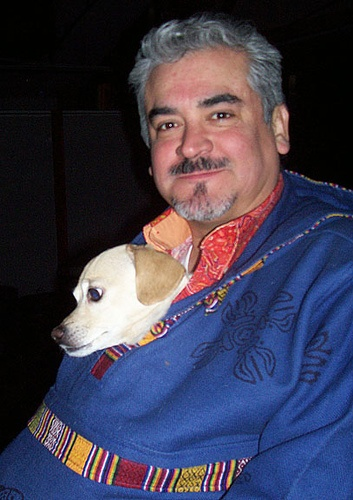

0
test_images/messi.jpg


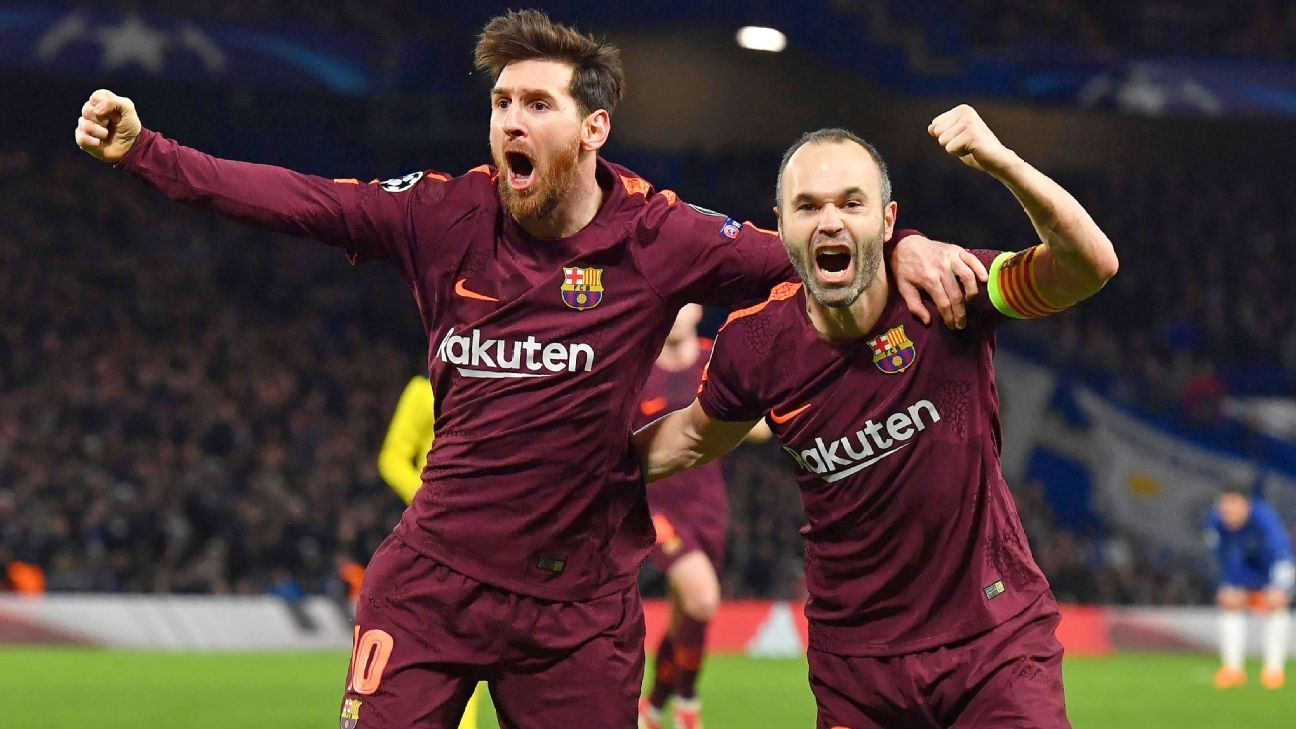

0
test_images/wonkacomments.jpg


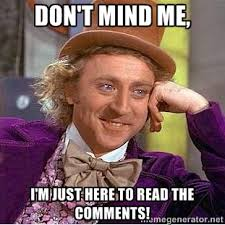

0
test_images/000021.jpg


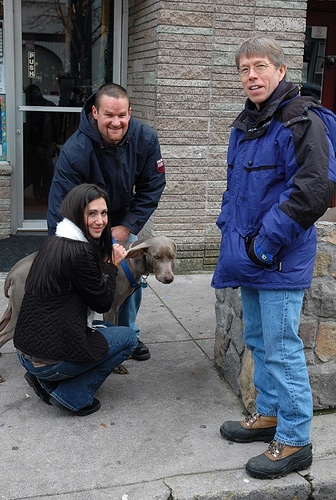

0


In [0]:
import pickle, glob
from google.colab.patches import cv2_imshow
CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
           'tvmonitor']
print(CLASSES)
def test(opt):
    if torch.cuda.is_available():
        if opt.pre_trained_model_type == "model":
            model = torch.load(opt.pre_trained_model_path)
        else:
            model = Yolo(20)
            model.load_state_dict(torch.load(opt.pre_trained_model_path))
    else:
        if opt.pre_trained_model_type == "model":
            model = torch.load(opt.pre_trained_model_path, map_location=lambda storage, loc: storage)
        else:
            model = Yolo(20)
            model.load_state_dict(torch.load(opt.pre_trained_model_path, map_location=lambda storage, loc: storage))
    model.eval()
    with open('pallete', "rb") as fin:
      colors = pickle.load(fin)
      print(colors)
#     colors = pickle.load(open("pallete", "rb"))

    for image_path in glob.iglob(opt.input + os.sep + '*.jpg'):
        print(image_path)
        if "prediction" in image_path:
            continue
        image = cv2.imread(image_path)
        cv2_imshow(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]
        image = cv2.resize(image, (opt.image_size, opt.image_size))
        image = np.transpose(np.array(image, dtype=np.float32), (2, 0, 1))
        image = image[None, :, :, :]
        width_ratio = float(opt.image_size) / width
        height_ratio = float(opt.image_size) / height
        data = Variable(torch.FloatTensor(image))
        if torch.cuda.is_available():
            data = data.cuda()
        with torch.no_grad():
            logits = model(data)
            predictions = post_processing(logits, opt.image_size, CLASSES, model.anchors, opt.conf_threshold,
                                          opt.nms_threshold)
            print(len(predictions))
        if len(predictions) != 0:
            predictions = predictions[0]
            output_image = cv2.imread(image_path)
            for pred in predictions:
                xmin = int(max(pred[0] / width_ratio, 0))
                ymin = int(max(pred[1] / height_ratio, 0))
                xmax = int(min((pred[0] + pred[2]) / width_ratio, width))
                ymax = int(min((pred[1] + pred[3]) / height_ratio, height))
                color = colors[CLASSES.index(pred[5])]
                cv2.rectangle(output_image, (xmin, ymin), (xmax, ymax), color, 2)
                text_size = cv2.getTextSize(pred[5] + ' : %.2f' % pred[4], cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                cv2.rectangle(output_image, (xmin, ymin), (xmin + text_size[0] + 3, ymin + text_size[1] + 4), color, -1)
                cv2.putText(
                    output_image, pred[5] + ' : %.2f' % pred[4],
                    (xmin, ymin + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1,
                    (255, 255, 255), 1)
                print("Object: {}, Bounding box: ({},{}) ({},{})".format(pred[5], xmin, xmax, ymin, ymax))
            cv2.imwrite(image_path[:-4] + "_prediction.jpg", output_image)
            cv2_imshow(output_image)

# if __name__ == "__main__":
dict_args = {'image_size':448, 'conf_threshold':0.35, 'nms_threshold':0.5, 'pre_trained_model_type':'model',\
             'input':"test_images", 'output':"test_images", 'pre_trained_model_path':'trained_models/whole_model_trained_yolo_voc'}
args = Argument(dict_args)
test(args)

In [0]:
with open('pallete', 'rb') as f:
  print(f.read())

b'\n\n\n\n\n\n<!DOCTYPE html>\n<html lang="en">\n  <head>\n    <meta charset="utf-8">\n  <link rel="dns-prefetch" href="https://github.githubassets.com">\n  <link rel="dns-prefetch" href="https://avatars0.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://avatars1.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://avatars2.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://avatars3.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">\n  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">\n\n\n\n  <link crossorigin="anonymous" media="all" integrity="sha512-HlgX4s+P4ikUGWRu6fvWIVak24jAHDOE7IzlHFtcW54px5zDZvAXO8xY42wXJNZ7PChlgxFwwdMH4tyMFCop6g==" rel="stylesheet" href="https://github.githubassets.com/assets/frameworks-2322f54af916007dd939df6c24bd2264.css" />\n  <link crossorigin="anonymous" media="all" integrity="sha512-pSSFGNiV1iXIGXRof04PZsZm/MshYNORLjGHBVeq9RJORXac9Ohy8vWsx

In [0]:
ls data/VOCdevkit/VOC2007/JPEGImages/

000001.jpg  001662.jpg  003323.jpg  004984.jpg  006645.jpg  008306.jpg
000002.jpg  001663.jpg  003324.jpg  004985.jpg  006646.jpg  008307.jpg
000003.jpg  001664.jpg  003325.jpg  004986.jpg  006647.jpg  008308.jpg
000004.jpg  001665.jpg  003326.jpg  004987.jpg  006648.jpg  008309.jpg
000005.jpg  001666.jpg  003327.jpg  004988.jpg  006649.jpg  008310.jpg
000006.jpg  001667.jpg  003328.jpg  004989.jpg  006650.jpg  008311.jpg
000007.jpg  001668.jpg  003329.jpg  004990.jpg  006651.jpg  008312.jpg
000008.jpg  001669.jpg  003330.jpg  004991.jpg  006652.jpg  008313.jpg
000009.jpg  001670.jpg  003331.jpg  004992.jpg  006653.jpg  008314.jpg
000010.jpg  001671.jpg  003332.jpg  004993.jpg  006654.jpg  008315.jpg
000011.jpg  001672.jpg  003333.jpg  004994.jpg  006655.jpg  008316.jpg
000012.jpg  001673.jpg  003334.jpg  004995.jpg  006656.jpg  008317.jpg
000013.jpg  001674.jpg  003335.jpg  004996.jpg  006657.jpg  008318.jpg
000014.jpg  001675.jpg  003336.jpg  004997.jpg  006658.jpg  008319.jpg
000015